### Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [ ]:
!pip install catboost

In [ ]:
import xgboost as xgb
from xgboost import plot_tree
from catboost import CatBoostClassifier

### Reading in the train, test and samplesubmission files

In [ ]:
train = pd.read_csv('/Train(1).csv')
test = pd.read_csv('/Test(1).csv')
sub = pd.read_csv('/SampleSubmission(1).csv')

In [ ]:
Train = train.copy()
Train = Train.set_index(['Applicant_ID'])
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


### Understanding the data set(train and test)

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, Apcnt_1000000 to Apcnt_999996
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   form_field1     53471 non-null  float64
 1   form_field2     52156 non-null  float64
 2   form_field3     55645 non-null  float64
 3   form_field4     55645 non-null  float64
 4   form_field5     55645 non-null  float64
 5   form_field6     42640 non-null  float64
 6   form_field7     50837 non-null  float64
 7   form_field8     42640 non-null  float64
 8   form_field9     47992 non-null  float64
 9   form_field10    55645 non-null  float64
 10  form_field11    24579 non-null  float64
 11  form_field12    46105 non-null  float64
 12  form_field13    50111 non-null  float64
 13  form_field14    56000 non-null  int64  
 14  form_field15    33525 non-null  float64
 15  form_field16    42964 non-null  float64
 16  form_field17    44849 non-null  float64
 17  form_field18    4

In [ ]:
Train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,2.457900e+04,4.610500e+04,5.011100e+04,5.600000e+04,3.352500e+04,42964.000000,44849.000000,45598.000000,55996.000000,55645.000000,40146.000000,35600.000000,27877.000000,42703.000000,50550.000000,48562.000000,46701.000000,55645.000000,55645.000000,30491.000000,16592.000000,50550.000000,54744.000000,55645.000000,32852.000000,54005.000000,50550.000000,55645.000000,51789.000000,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,2.054715e+06,2.771113e+06,6.009944e+06,6.914875e+07,1.145041e+08,0.230425,0.265692,0.271832,0.948800,1.031593,86.500380,6628.316381,6452.875072,104.558516,2624.555935,10106.554899,6190.516948,17274.315141,16518.540695,5213.246663,10857.565755,938.345321,13.926583,0.230245,0.199866,12.859069,8.480435,8.601420,0.090849,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,4.912980e+06,4.544838e+06,2.335893e+07,2.713995e+09,1.153842e+08,0.621833,0.720198,0.725434,1.736454,1.785122,53.445528,5661.059297,5739.968774,436.670719,1964.226548,8796.472481,5390.915344,26930.742020,9666.183962,3124.491488,6049.678489,1044.597044,15.208396,0.683063,0.574002,10.621984,9.328810,7.969215,0.423802,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.395430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,2.172565e+05,2.758010e+05,1.921660e+05,1.657646e+07,5.007636e+07,0.000000,0.000000,0.000000,0.000000,0.000000,40.305000,1068.667500,797.145000,14.865000,1231.500000,3375.000000,2068.000000,60.000000,9765.000000,2312.000000,6297.000000,194.000000,2.333400,0.000000,0.000000,6.000000,2.000000,4.000000,0.000000,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,6.986440e+05,1.163110e+06,1.605792e+06,2.814143e+07,8.442428e+07,0.000000,0.000000,0.000000,0.000000,0.000000,89.167500,5976.225000,5548.935000,60.660000,2203.500000,8214.000000,5110.000000,486.000000,15057.000000,5658.000000,10584.000000,598.000000,7.833400,0.000000,0.000000,10.000000,6.000000,6.000000,0.000000,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552

In [ ]:
Train.describe(include = 'all')

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,2.457900e+04,4.610500e+04,5.011100e+04,5.600000e+04,3.352500e+04,42964.000000,44849.000000,45598.000000,55996.000000,55645.000000,40146.000000,35600.000000,27877.000000,42703.000000,50550.000000,48562.000000,46701.000000,55645.000000,55645.000000,30491.000000,16592.000000,50550.000000,54744.000000,55645.000000,32852.000000,54005.000000,50550.000000,55645.000000,51789.000000,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,56000,3.511100e+04,55645.000000,4.494400e+04,56000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,charge,NaN,NaN,NaN,no
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36373,NaN,NaN,NaN,42285
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,2.054715e+06,2.771113e+06,6.009944e+06,6.914875e+07,1.145041e+08,0.230425,0.265692,0.271832,0.948800,1.031593,86.500380,6628.316381,6452.875072,104.558516,2624.555935,10106.554899,6190.516948,17274.315141,16518.540695,5213.246663,10857.565755,938.345321,13.926583,0.230245,0.199866,12.859069,8.480435,8.601420,0.090849,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,NaN,3.052449e+05,1.049061,6.005862e+05,NaN
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,4.912980e+06,4.544838e+06,2.335893e+07,2.713995e+09,1.153842e+08,0.621833,0.720198,0.725434,1.736454,1.785122,53.445528,5661.059297,5739.968774,436.670719,1964.226548,8796.472481,5390.915344,26930.742020,9666.183962,3124.491488,6049.678489,1044.597044,15.208396,0.683063,0.574002,10.621984,9.328810,7.969215,0.423802,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,NaN,1.647757e+06,1.806160,5.842405e+06,NaN
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.395430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,NaN,0.000000e+00,0.000000,0.000000e+00,NaN
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,2.172565e+05,2.758010e+05,1.921660e+05,1.657646e+07,5.007636e+07,0.000000,0.000000,0.000000,0.000000,0.000000,40.305000,1068.667500,797.145000,14.865000,1231.500000,3375.000000,2068.000000,60.000000,9765.000000,2312.000000,6297.000000,194.000000,2.333400,0.000000,0.000000,6.000000,2.000000,4.000000,0.000000,136.191750,87.055500,0.000000,2.020000,

Finding numeric and categorical columns

In [ ]:
numeric = Train.select_dtypes(exclude = 'object')
numeric.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field48', 'form_field49',
       'form_field50'],
      dtype='object')

In [ ]:
objects = Train.select_dtypes(include = 'object')
objects.columns

Index(['form_field47', 'default_status'], dtype='object')

In [ ]:
Train.isnull().sum()

form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41      38229
form_field42    

In [ ]:
Train.shape

(56000, 51)

In [ ]:
Train['form_field47'].value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [ ]:
Test = test.set_index(['Applicant_ID'])
Test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, Apcnt_1000032 to Apcnt_999992
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   form_field1   22890 non-null  float64
 1   form_field2   22291 non-null  float64
 2   form_field3   23854 non-null  float64
 3   form_field4   23854 non-null  float64
 4   form_field5   23854 non-null  float64
 5   form_field6   18396 non-null  float64
 6   form_field7   21769 non-null  float64
 7   form_field8   18396 non-null  float64
 8   form_field9   20600 non-null  float64
 9   form_field10  23853 non-null  float64
 10  form_field11  10602 non-null  float64
 11  form_field12  19817 non-null  float64
 12  form_field13  21537 non-null  float64
 13  form_field14  24000 non-null  int64  
 14  form_field15  14408 non-null  float64
 15  form_field16  18526 non-null  float64
 16  form_field17  19305 non-null  float64
 17  form_field18  19631 non-null  float64
 18  form_field19

In [ ]:
Test.isnull().sum()

form_field1      1110
form_field2      1709
form_field3       146
form_field4       146
form_field5       146
form_field6      5604
form_field7      2231
form_field8      5604
form_field9      3400
form_field10      147
form_field11    13398
form_field12     4183
form_field13     2463
form_field14        0
form_field15     9592
form_field16     5474
form_field17     4695
form_field18     4369
form_field19        0
form_field20      147
form_field21     6707
form_field22     8724
form_field23    12125
form_field24     5605
form_field25     2256
form_field26     3172
form_field27     3910
form_field28      147
form_field29      147
form_field30    10908
form_field31    16810
form_field32     2256
form_field33      495
form_field34      147
form_field35     9866
form_field36      903
form_field37     2256
form_field38      147
form_field39     1829
form_field40    18828
form_field41    16349
form_field42      578
form_field43      250
form_field44     2362
form_field45    13538
form_field

In [ ]:
Test['form_field47'].value_counts()

charge     15467
lending     8533
Name: form_field47, dtype: int64

### Preprocessing and cleaning of the data set(train and test)

In [ ]:
Train.replace('no', 0, inplace = True)
Train.replace('yes', 1, inplace = True)
Train.head(3)

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.80573,1.620483,0.322436,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,1


In [ ]:
Train = pd.get_dummies(Train)
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,NaN,1.129518,0.044335,0,1,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,349.805730,1.620483,0.322436,0,1,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,NaN,1.513370,0.011640,1,1,0
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,89.940100,0.664452,0.082729,0,1,0
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,97.887502,1.427891,0.045630,0,1,0


In [ ]:
Test = pd.get_dummies(Test)
Test.head(3)

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,NaN,238.0,1.8334,0.0,NaN,22.0,2.0,14.0,0.0,NaN,NaN,0.825000,1.01,0.800000,NaN,0.0,NaN,0.000000,0.011221,1,0
Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.56,NaN,NaN,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,NaN,1216.0,19.5000,3.0,NaN,30.0,18.0,14.0,2.0,NaN,18.8415,0.507694,4.04,0.623248,1.0,0.0,NaN,0.504974,0.043525,0,1
Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,118256.0,NaN,NaN,21973443,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,NaN,NaN,7.8334,0.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.000000,NaN,1,0


In [ ]:
Train.fillna(-999, inplace = True)
Train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,-999.00,-999.00,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,-999.0,1052.0,8.0000,2.0,-999.0,12.0,12.0,4.0,0.0,-999.0000,-999.0,0.392854,2.02,0.711632,0.0,0.0,-999.000000,1.129518,0.044335,0,1,0
Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,-999.0,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,-999.0000,-999.0,0.314281,8.08,0.183584,-999.0,0.0,349.805730,1.620483,0.322436,0,1,0
Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,-999.0,956940.0,-999.0,192944.0,1079864.0,-999.0,-999.0,0.0,16576457,22452691.0,-999.0,-999.0,-999.0,0.0,0.0,-999.000,-999.00,-999.00,-999.000,1597.5,4746.0,3164.0,60.0,15696.0,-999.0,14508.0,70.0,0.6666,0.0,-999.0,12.0,0.0,6.0,0.0,149.6805,-999.0,0.162965,18.18,0.791136,0.0,0.0,-999.000000,1.513370,0.011640,1,1,0
Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,-999.0,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,-999.0,-999.0,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,-999.0000,-999.0,0.488884,2.02,0.685168,-999.0,0.0,89.940100,0.664452,0.082729,0,1,0
Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,-999.0,0.275000,12.12,0.438168,0.0,0.0,97.887502,1.427891,0.045630,0,1,0


In [ ]:
Test.fillna(-999, inplace = True)
Test.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50,form_field47_charge,form_field47_lending
Applicant_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,-999.000,-999.00,-999.00,-999.000,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,-999.0,238.0,1.8334,0.0,-999.0,22.0,2.0,14.0,0.0,-999.0,-999.0000,0.825000,1.01,0.800000,-999.0,0.0,-999.000000,0.000000,0.011221,1,0
Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.560,-999.00,-999.00,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,-999.0,1216.0,19.5000,3.0,-999.0,30.0,18.0,14.0,2.0,-999.0,18.8415,0.507694,4.04,0.623248,1.0,0.0,-999.000000,0.504974,0.043525,0,1
Apcnt_1000052,-999.0,0.27505,0.0600,0.0000,0.0,-999.0,-999.0,-999.0,-999.0,0.0,118256.0,-999.0,-999.0,21973443,-999.0,-999.0,-999.0,-999.0,0.0,0.0,-999.000,-999.00,-999.00,-999.000,-999.0,-999.0,-999.0,852.0,4836.0,-999.0,-999.0,-999.0,7.8334,0.0,-999.0,2.0,-999.0,0.0,-999.0,-999.0,-999.0000,-999.000000,0.00,-999.000000,-999.0,-999.0,-999.000000,0.000000,-999.000000,1,0
Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1391064.0,1176725.0,1220293.0,16576457,-999.0,2.0,2.0,2.0,3.0,3.0,109.005,13050.00,-999.00,109.005,1414.5,4197.0,2798.0,60.0,14964.0,-999.0,-999.0,248.0,9.0000,1.0,1.0,36.0,0.0,26.0,0.0,-999.0,-999.0000,0.916663,2.02,0.464224,-999.0,-999.0,90.163742,0.788809,0.104029,1,0
Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,271133.0,613064.0,4779643.0,48187375,72049802.0,0.0,0.0,0.0,3.0,3.0,139.065,469.29,469.29,15.180,2724.0,9855.0,6570.0,182.0,11679.0,5900.0,-999.0,2388.0,16.6666,1.0,0.0,24.0,28.0,20.0,0.0,-999.0,-999.0000,0.234047,23.23,0.726688,0.0,0.0,1303.587148,1.637733,0.163124,0,1


### Visualizing and Exploring the train set

13715
42285


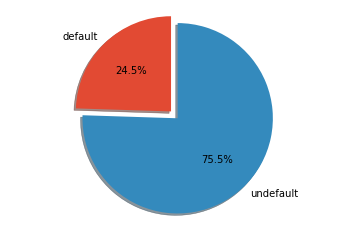

In [ ]:
labels = 'default', 'undefault'
default_size = 0
undefault_size = 0
for i in Train['default_status']:
    if i == 1:
        default_size += 1
    else:
        undefault_size +=1
print(default_size)
print(undefault_size)
sizes = [(default_size / len(Train)) * 100, (undefault_size / len(Train)) * 100]
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'default')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

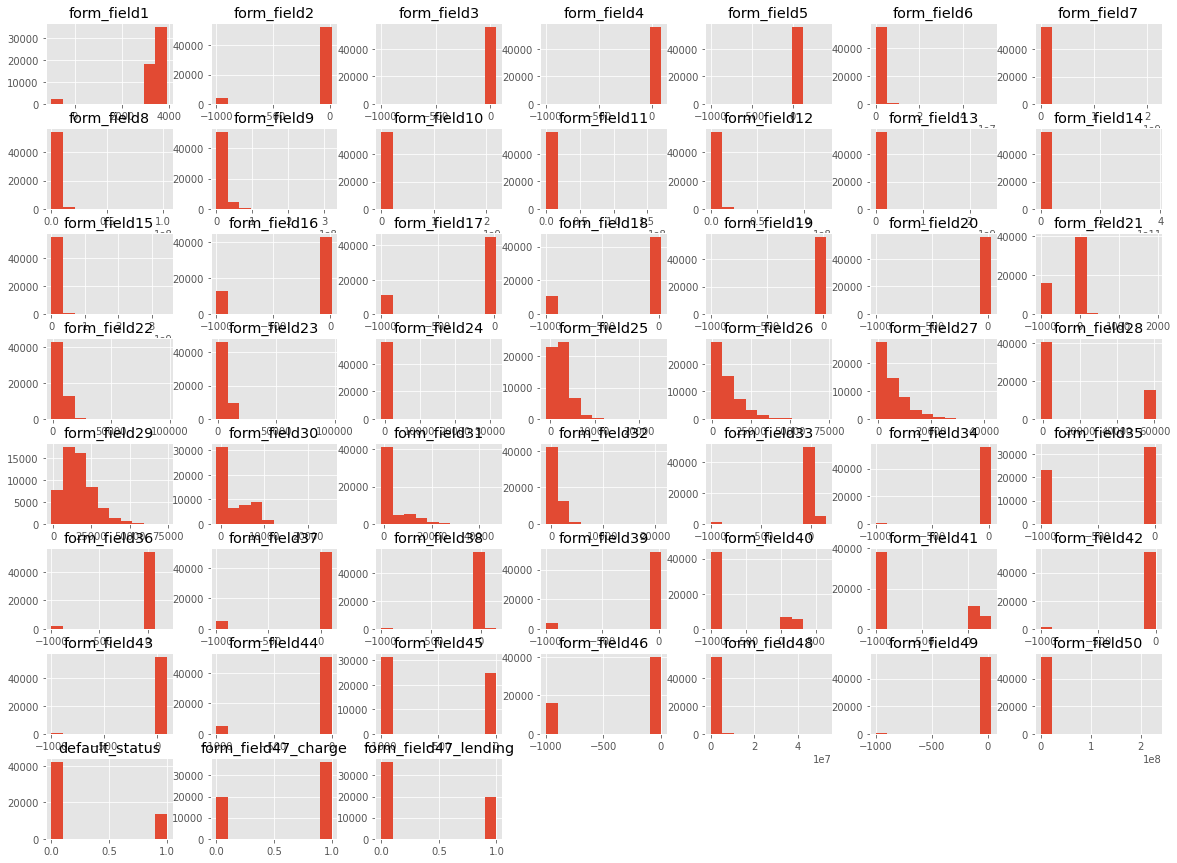

In [ ]:
Train.hist(bins=10, figsize=(20, 15))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


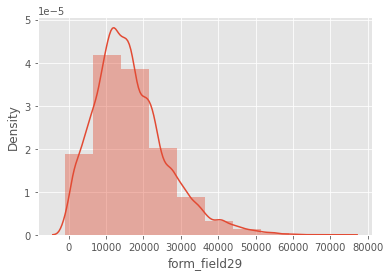

In [ ]:
sns.distplot(Train['form_field29'], bins=10)

Determining correlation between target and features

In [ ]:
corrMatrix = Train.corr()
corrMatrix

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50,default_status,form_field47_charge,form_field47_lending
form_field1,1.000000,0.066395,0.358717,0.359764,0.355599,0.155828,0.123642,0.230769,0.229502,0.172198,-0.089929,0.150727,0.093389,-0.021031,0.092517,0.431777,0.458290,0.460704,0.054589,0.361945,0.371567,0.108731,0.083393,0.322807,0.332689,0.302250,0.303718,0.155923,0.291305,0.171175,0.082676,0.355534,0.106149,0.360407,0.241815,0.285131,0.491966,0.364180,0.622855,0.079766,0.150026,0.413058,0.381166,0.579925,0.240394,0.281385,0.054497,0.361472,0.040527,-0.140965,-0.090533,0.090533
form_field2,0.066395,1.000000,0.080174,0.080579,0.080074,-0.138547,-0.032814,-0.090430,-0.026720,-0.027382,0.012688,0.022158,-0.012013,-0.007145,-0.008544,0.055683,0.057080,0.057772,0.026108,0.081049,0.069337,0.166758,0.145292,0.054365,-0.140681,-0.088207,-0.086130,-0.113445,-0.092637,0.055030,0.041341,-0.032589,0.005889,0.079351,0.206719,0.091039,0.063798,0.097107,0.083604,0.052440,0.113881,0.070366,0.080117,0.094005,-0.021014,0.105363,-0.002065,0.080659,0.024883,0.073846,0.097002,-0.097002
form_field3,0.358717,0.080174,1.000000,0.999254,0.993343,0.025861,0.024715,0.038259,0.041953,0.031477,0.030722,0.038149,0.016790,-0.030710,0.015772,0.136770,0.152245,0.159336,0.111975,0.999346,0.119697,0.065471,0.053084,0.107872,0.118576,0.082369,0.082392,0.045485,0.140925,0.070512,0.049570,0.118484,0.150281,0.999621,0.091056,0.417024,0.241281,0.995056,0.276831,0.046772,0.052861,0.491087,0.787299,0.241327,0.067352,0.127518,0.010087,0.999499,0.006288,0.009359,-0.006916,0.006916
form_field4,0.359764,0.080579,0.999254,1.000000,0.991149,0.026420,0.025235,0.039185,0.042613,0.032431,0.025518,0.038887,0.017195,-0.030709,0.016036,0.137795,0.152967,0.159954,0.111989,0.998931,0.120604,0.065385,0.052822,0.106595,0.117680,0.081276,0.081334,0.047075,0.140412,0.073910,0.046715,0.117139,0.150386,0.999212,0.091366,0.416246,0.240333,0.994600,0.277598,0.045198,0.054992,0.490614,0.786950,0.242454,0.067842,0.133351,0.010339,0.998938,0.006456,0.009983,-0.007203,0.007203
form_field5,0.355599,0.080074,0.993343,0.991149,1.000000,0.021725,0.020352,0.032050,0.034483,0.025820,0.052391,0.031910,0.013911,-0.030823,0.011432,0.121704,0.135747,0.142585,0.110062,0.991007,0.106645,0.061349,0.049722,0.094787,0.108797,0.072006,0.071907,0.037931,0.134865,0.064811,0.075906,0.106186,0.147800,0.991395,0.082693,0.416548,0.229409,0.986949,0.268839,0.062885,0.048353,0.488447,0.780580,0.232281,0.056543,0.121485,0.008272,0.992554,0.005129,0.015713,-0.003183,0.003183
form_field6,0.155828,-0.138547,0.025861,0.026420,0.021725,1.000000,0.207660,0.522087,0.289385,0.258334,-0.071671,0.003930,0.183866,-0.000700,0.132512,0.204917,0.185440,0.177611,-0.033103,0.025788,0.104013,-0.178472,-0.162650,0.069625,0.318613,0.255407,0.255463,0.320936,0.237581,0.017363,-0.052720,0.199499,0.031733,0.028987,-0.067531,-0.042113,0.125746,0.013946,0.106078,-0.098012,-0.039541,0.018392,0.009114,0.092688,0.179975,-0.005218,0.030454,0.025554,0.067747,-0.173197,-0.139724,0.139724
form_field7,0.123642,-0.032814,0.024715,0.025235,0.020352,0.207660,1.000000,0.357153,0.293446,0.900846,-0.050529,0.145371,0.296013,0.000341,0.172566,0.132331,0.127726,0.127623,-0.005317,0.026494,0.105633,-0.065900,-0.067408,0.084068,0.240682,0.252058,0.251314,0.147961,0.233896,0.075241,-0.050896,0.260338,0.022445,0.027117,0.009295,0.034974,0.104875,0.020393,0.096939,-0.077087,0.022664,0.0452

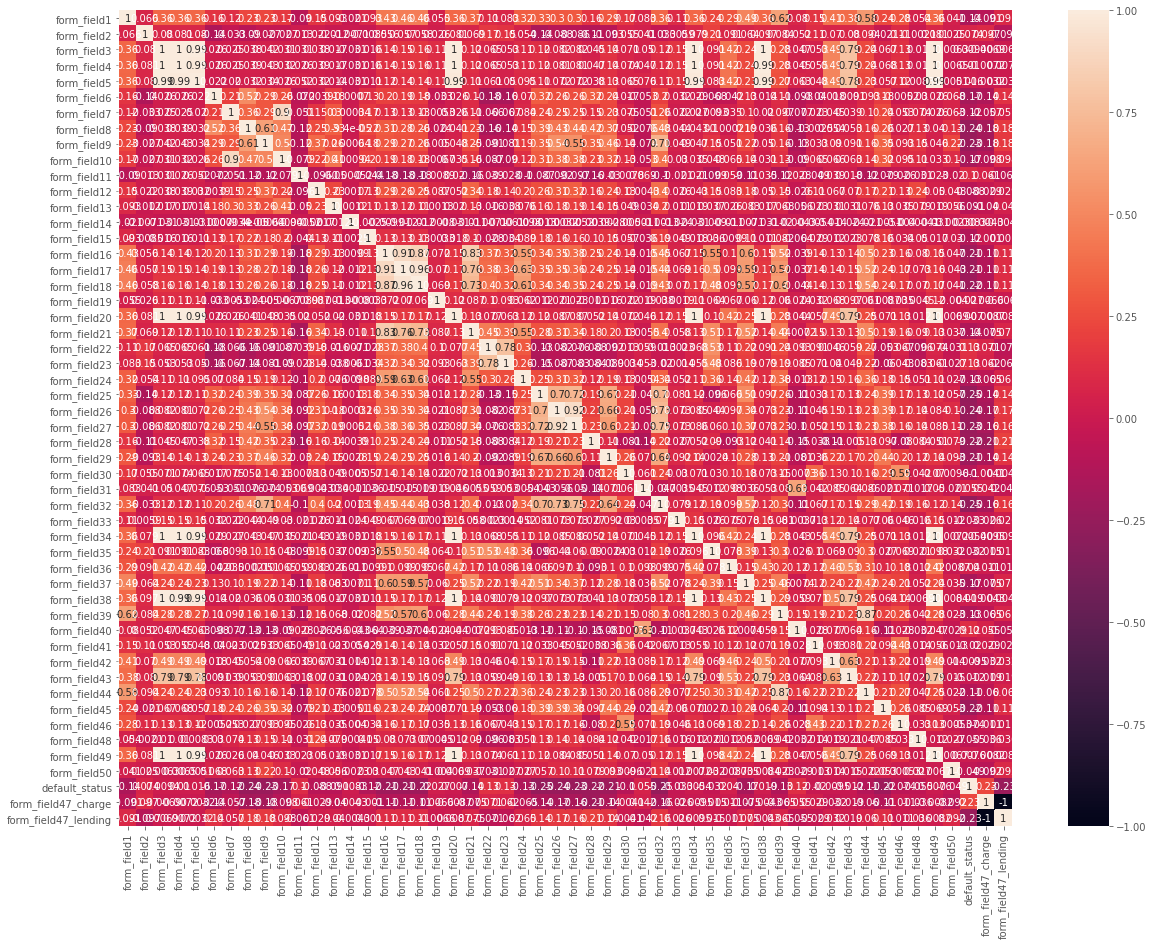

In [ ]:
plt.subplots(figsize = (20, 15))
sns.heatmap(corrMatrix, annot = True)
plt.show()

In [ ]:
Train.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field48', 'form_field49',
       'form_field50', 'default_status', 'form_field47_charge',
       'form_field47_lending'],
      dtype='object')

### Determining and Building the best model

In [ ]:
X = np.array(Train.drop(['default_status'], 1))
y = np.array(Train['default_status'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
print(Train.shape)
print(Test.shape)

(56000, 52)
(24000, 51)


xgboost classifier

In [ ]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1)
xgb_clf.fit(X_train, y_train)
preds1 = xgb_clf.predict_proba(X_test)[:,1]
accuracy1 = xgb_clf.score(X_test, y_test)
print(accuracy1)

0.808125


In [ ]:
auc_df = roc_auc_score(y_test, preds1)
auc_df

0.8310124691046903

catboost classifier

In [ ]:
cat_clf = CatBoostClassifier(verbose=False)
cat_clf.fit(X_train, y_train)
preds3 = cat_clf.predict_proba(X_test)
accuracy3 = cat_clf.score(X_test, y_test)
print(accuracy3)

0.8091071428571428


In [ ]:
auc_cat = roc_auc_score(y_test, preds3[:,1])
auc_cat

0.8370318115528094

lightgbm classifier

In [ ]:
import lightgbm as lgb
lg_clf = lgb.LGBMClassifier(learning_rate=0.01, num_iterations=2500, scale_pos_weight=3, max_depth=4)
lg_clf.fit(X_train, y_train)
preds4 = lg_clf.predict_proba(X_test)
accuracy4 = lg_clf.score(X_test, y_test)
print(accuracy4)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.746875


In [ ]:
lg_cat = roc_auc_score(y_test, preds4[:,1])
lg_cat

0.8362065544341879

randomforest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
preds5 = rf_clf.predict_proba(X_test)
accuracy5 = rf_clf.score(X_test, y_test)
print(accuracy5)

0.8046428571428571


In [ ]:
rf_auc = roc_auc_score(y_test, preds5[:,1])
rf_auc

0.8304646206478884

xgb tuned

In [ ]:
xgb_clf = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=3, eta=0.01, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='auc', seed=5, nthread=4)
xgb_clf.fit(X_train, y_train)
predstun = xgb_clf.predict_proba(X_test)
accuracytun = xgb_clf.score(X_test, y_test)
print(accuracytun)

0.7473214285714286


In [ ]:
auc_df = roc_auc_score(y_test, predstun[:,1])
auc_df

0.8353853787702872

Using the best model on the Test set

In [ ]:
X = Train.drop(['default_status'], 1)
y = Train['default_status']

In [ ]:
X.shape

(56000, 51)

In [ ]:
Test.shape

(24000, 51)

stratified kfold to predict on test data with catboost

In [ ]:
#Test = Test.set_index(['Applicant_ID'])

In [ ]:
skfold = StratifiedKFold(n_splits=25, random_state=0, shuffle=True)

scores = []
preds = []
i = 1
cat = CatBoostClassifier(verbose=False)

for train_split, test_split in skfold.split(X, y):
    Xtrain, Xtest, ytrain, ytest = X.iloc[train_split], X.iloc[test_split], y[train_split], y[test_split]
    cat.fit(Xtrain, ytrain)
    score = roc_auc_score(ytest, cat.predict_proba(Xtest)[:,1])
    pred = cat.predict_proba(Test)[:,1]
    scores.append(score)
    preds.append(pred)
    print('AUC Score for {} split:'.format(i), score)
    i+=1
print('Final score:', np.mean(scores))
Final_pred1 = np.mean(preds, axis = 0)

AUC Score for 1 split: 0.8325093613570085
AUC Score for 2 split: 0.8460747010405343
AUC Score for 3 split: 0.8353037479939949
AUC Score for 4 split: 0.8322645424582836
AUC Score for 5 split: 0.838814256872185
AUC Score for 6 split: 0.854275594899139
AUC Score for 7 split: 0.845760858311332
AUC Score for 8 split: 0.8234780245379718
AUC Score for 9 split: 0.8328738934617177
AUC Score for 10 split: 0.8365418629531844
AUC Score for 11 split: 0.847058088519635
AUC Score for 12 split: 0.8408471291817066
AUC Score for 13 split: 0.8301152894516022
AUC Score for 14 split: 0.8536191279451161
AUC Score for 15 split: 0.8484519458528436
AUC Score for 16 split: 0.8450243925033312
AUC Score for 17 split: 0.8364641264855514
AUC Score for 18 split: 0.8277250503307448
AUC Score for 19 split: 0.8424251824994425
AUC Score for 20 split: 0.8522328107984087
AUC Score for 21 split: 0.8429325293340185
AUC Score for 22 split: 0.8224178362034514
AUC Score for 23 split: 0.8517405443368352
AUC Score for 24 split: 

stratified kfold to predict test data with voting classifier(xgboost and catboost)

In [ ]:
skfold = StratifiedKFold(n_splits=25, random_state=0, shuffle=True)

scores = []
preds = []
i = 1
vc = VotingClassifier(estimators= [('xg', xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=3, eta=0.01, n_estimators=500, max_depth=3, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='auc', seed=5, nthread=4)), ('cat', CatBoostClassifier(verbose=False))], voting='soft')

for train_split, test_split in skfold.split(X, y):
    Xtrain, Xtest, ytrain, ytest = X.iloc[train_split], X.iloc[test_split], y[train_split], y[test_split]
    vc.fit(Xtrain, ytrain)
    score = roc_auc_score(ytest, vc.predict_proba(Xtest)[:,1])
    pred = vc.predict_proba(Test)[:,1]
    scores.append(score)
    preds.append(pred)
    print('AUC Score for {} split:'.format(i), score)
    i+=1
print('Final score:', np.mean(scores))
Final_pred2 = np.mean(preds, axis = 0)

AUC Score for 1 split: 0.8305842435850977
AUC Score for 2 split: 0.8461189194319338
AUC Score for 3 split: 0.8376020258494244
AUC Score for 4 split: 0.831605580576694
AUC Score for 5 split: 0.8394074304153509
AUC Score for 6 split: 0.8538118410381184
AUC Score for 7 split: 0.846544925885662
AUC Score for 8 split: 0.821440743041535
AUC Score for 9 split: 0.831855791962175
AUC Score for 10 split: 0.8372288657659056
AUC Score for 11 split: 0.8459227518664654
AUC Score for 12 split: 0.8419016781223643
AUC Score for 13 split: 0.8306409481676809
AUC Score for 14 split: 0.8521994185439039
AUC Score for 15 split: 0.8476699207957268
AUC Score for 16 split: 0.8449317559263172
AUC Score for 17 split: 0.8358048987514529
AUC Score for 18 split: 0.832837296778509
AUC Score for 19 split: 0.8422054399214097
AUC Score for 20 split: 0.8538841116421557
AUC Score for 21 split: 0.843866435290658
AUC Score for 22 split: 0.8211435446847609
AUC Score for 23 split: 0.8526098201234653
AUC Score for 24 split: 0.

Stratified kfold to predict test data with voting classifier(lightgbm, catboost and randomforest).

In [ ]:
skfold = StratifiedKFold(n_splits=25, random_state=0, shuffle=True)

scores = []
preds = []
i = 1
vc = VotingClassifier(estimators= [('lg_clf', lgb.LGBMClassifier(learning_rate=0.01, num_iterations=2500, scale_pos_weight=3, max_depth=4)), ('cat', CatBoostClassifier(verbose=False)), ('rf_clf', RandomForestClassifier())], voting='soft')

for train_split, test_split in skfold.split(X, y):
    Xtrain, Xtest, ytrain, ytest = X.iloc[train_split], X.iloc[test_split], y[train_split], y[test_split]
    vc.fit(Xtrain, ytrain)
    score = roc_auc_score(ytest, vc.predict_proba(Xtest)[:,1])
    pred = vc.predict_proba(Test)[:,1]
    scores.append(score)
    preds.append(pred)
    print('AUC Score for {} split:'.format(i), score)
    i+=1
print('Final score:', np.mean(scores))
Final_pred3 = np.mean(preds, axis = 0)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 1 split: 0.8340958309606391


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 2 split: 0.8476902900726476


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 3 split: 0.8379741074355922


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 4 split: 0.8334951079360148


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 5 split: 0.8415622681230694


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 6 split: 0.8556722489689566


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 7 split: 0.8477603924004763


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 8 split: 0.8228751445186451


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 9 split: 0.8326851564252558


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 10 split: 0.8385672809787579


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 11 split: 0.848005997679777


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 12 split: 0.8428420470960049


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 13 split: 0.8314068156822954


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 14 split: 0.8563055886785178


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 15 split: 0.8466519956180745


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 16 split: 0.8441820459542052


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 17 split: 0.8371352030841517


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 18 split: 0.8350142563383346


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 19 split: 0.8413943312877885


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 20 split: 0.8532054948570542


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 21 split: 0.8454897297274008


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 22 split: 0.8230113565980401


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 23 split: 0.852983597940021


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 24 split: 0.8395965353920196


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC Score for 25 split: 0.8548007828867927
Final score: 0.8417761442656212


In [ ]:
default_status1 = Final_pred1

In [ ]:
default_status2 = Final_pred2

In [ ]:
default_status3 = Final_pred3

In [ ]:
Final_pred4 = Final_pred1*0.4 + Final_pred2*0.6

In [ ]:
Final_pred5 = Final_pred3*0.7 + Final_pred2*0.3

Final Prediction (Weighted average - votingclassifier(lightgbm, catboost, and random forest) and weighted average of catboost and xgboost)

In [ ]:
Final_pred6 = Final_pred3*0.7 + Final_pred4*0.3

In [ ]:
default_status6 = Final_pred6

In [ ]:
Test = Test.reset_index()

In [ ]:
predicted_values6 = pd.DataFrame({'Applicant_ID': Test['Applicant_ID'], 'default_status': default_status6}) 
predicted_values6

,Applicant_ID,default_status
0,Apcnt_1000032,0.411899
1,Apcnt_1000048,0.399594
2,Apcnt_1000052,0.497011
3,Apcnt_1000076,0.783711
4,Apcnt_1000080,0.227037
...,...,...
23995,Apcnt_999940,0.748793
23996,Apcnt_999956,0.354005
23997,Apcnt_999976,0.359800
23998,Apcnt_999984,0.606497


In [ ]:
predicted_values6.to_csv('FinSub3.csv', index = False)